# Leap Multitask Demo

This notebook showcases the use of Leap [[link]](https://openreview.net/pdf?id=HygBZnRctX). Leap is a meta-learning algorithm that aims at learning a model, that can be quickly adapted to learn a set of related tasks.

In meta-learning, we assume that we want to represent a set of related tasks sampled from a common underlying distribution. To do so, we have access to a subset of those tasks that we use for training. Using this subset, the goal is to learn a model that it is a good initialization, i.e., that can be quickly adapted to solve any new tasks (not used during training) sampled from the same tasks’ distribution.

To do so, Leap iterates between:

* Training the model to solve each of the training tasks individually, using gradient descent from a common initialization. This defines a gradient path for each of the tasks.
* Optimizing the initialization by building a meta-objective that minimizes the average length of the gradient paths across all the observed training tasks.

More details of the algorithm can be found in the paper [[link]](https://openreview.net/pdf?id=HygBZnRctX).


Date: 2019/03/19


```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

In [1]:
from mxnet import nd, autograd, gluon
import mxnet as mx


import numpy as np

import xfer.contrib.xfer_leap as leap
from xfer.contrib.xfer_leap.synthetic_data import MetaTaskSynthetic

### Set contexts

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## Define tasks

To demo Leap we use a synthetic dataset. Each task consists of a linear regression characterized by a set of weights. To represent each task, we generate a dataset where the covariates are sampled from a standard normal distribution. The labels are the output of the corresponding linear regressor corrupted by a normal additive noise. We generate four training tasks in total.

In [3]:
config = {
    # Number examples per task and input dimensionality
    "num_examples_per_task": 300,
    "dim": 2,
    # task dependent bias and task independent bias
    "global_bias": 4.0,
    "task_bias": False,
    # Standard deviation of the covariates and the additive noise to the output
    "std_x": 1.0,
    "std_noise": 0.01,
    # Total number of tasks used for training/test
    "num_tasks_train": 4,
    "num_tasks_test": 0,
    "num_tasks_val": 0,
    # Total number of examples in each task that are hold out
    "hold_out": 100
    }

In [4]:
W = mx.nd.array([[0, 100, 20], [0, 120, 38], [0, 70, 70], [0, 39, 115]], ctx=data_ctx)

In [5]:
m = MetaTaskSynthetic(config, weights=W[:,1:], bias=W[:,0], context=mx.cpu(1))

Finally, for each of the generated task datasets, we construct a data iterator for mini-bacth learning.

In [6]:
batch_size = 4
train_data_all = m.get_train_tasks_iterators(batch_size=batch_size, train=True)

## Define and initialize network

In addition to the tasks' data iterators, Leap requires an input_model. This is the model that will be optimized to be able to quickly learn any new test task sampled from the same distribution. Here, we randomly initialize the parameters of the model. If we had a better initialization point, e.g. a relevant pretrained model, we could use it instead. 

In [7]:
net = gluon.nn.Dense(1, in_units=2, use_bias=False)

print(net.weight)
print(net.bias)

Parameter dense0_weight (shape=(1, 2), dtype=float32)
None


In [8]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Leap MetaRepurposer

Here we meta-train the input_model. Each meta_step consists of two parts:
* Individual task learning loop (inner loop): For each of the training tasks in the meta_batch, we train a model starting at the current initialization.
* Meta-update (outer loop): The initialization point is refined by minimizing the average length of the gradients paths collected in the inner loop.

In [9]:
lmr = leap.leap_meta_repurposer.LeapMetaRepurposer(model=net,
                                                   num_meta_steps=10,
                                                   num_epochs=7,
                                                   verbosity=2,
                                                   log_params=True)

In [10]:
lmr.repurpose(train_data_all, meta_batch_size=3)

	Metastep: 0, Task: 3, Initial Loss: 1524.065, Final Loss: 55.841, Loss delta: -1468.223
	Metastep: 0, Task: 3, Initial Loss: 1524.065, Final Loss: 55.841, Loss delta: -1468.223
	Metastep: 0, Task: 3, Initial Loss: 1524.065, Final Loss: 55.841, Loss delta: -1468.223
Metastep: 0, Num tasks: 3, Mean Loss: 48.655
	Metastep: 1, Task: 3, Initial Loss: 1226.433, Final Loss: 45.343, Loss delta: -1181.090
	Metastep: 1, Task: 3, Initial Loss: 1226.433, Final Loss: 45.343, Loss delta: -1181.090
	Metastep: 1, Task: 3, Initial Loss: 1226.433, Final Loss: 45.343, Loss delta: -1181.090
Metastep: 1, Num tasks: 3, Mean Loss: 47.456
	Metastep: 2, Task: 0, Initial Loss: 780.664, Final Loss: 26.031, Loss delta: -754.633
	Metastep: 2, Task: 2, Initial Loss: 543.722, Final Loss: 32.184, Loss delta: -511.538
	Metastep: 2, Task: 2, Initial Loss: 543.722, Final Loss: 32.184, Loss delta: -511.538
Metastep: 2, Num tasks: 3, Mean Loss: 38.855
	Metastep: 3, Task: 2, Initial Loss: 484.459, Final Loss: 29.131, Loss

## Plot Logs

For each task, we represent the value of the loss function against the number of epochs. We can observe that the area under this curve decreases for each of the meta-steps, showing that the meta-steps move the initialization point in the right direction, producing new models that can be adapted faster to the final tasks.

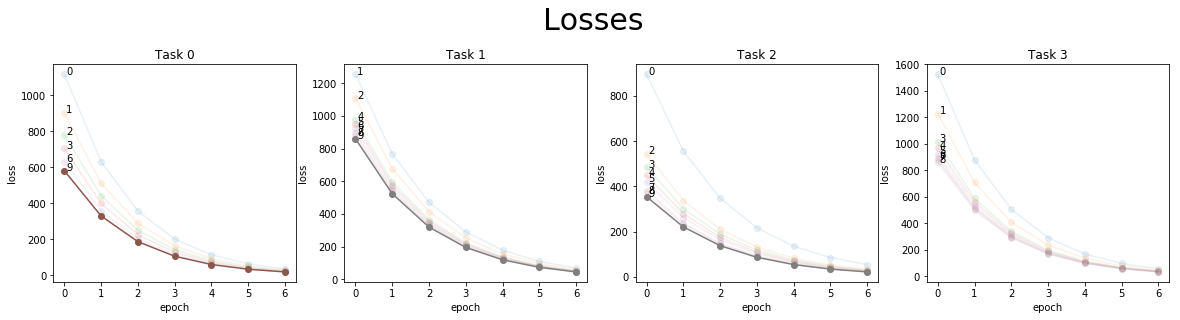

In [11]:
lmr.meta_logger.plot_losses()

The figure below summarizes  the evolution of the meta-learning process. In each of the figures, the background represents the value of the loss function for a different task. 

The lines represent the gradient path of each task (the task matching the background is highlighted in red). These lines have a common initialization that it is refined at each meta-step with the goal of minimizing the average length of the gradient paths. 

The final initialization, i.e. after meta-learning, is highlighted in pink (notice that this is the actual final output of the algorithm). Previous initializations are semi-transparent showing the meta-learning process. 


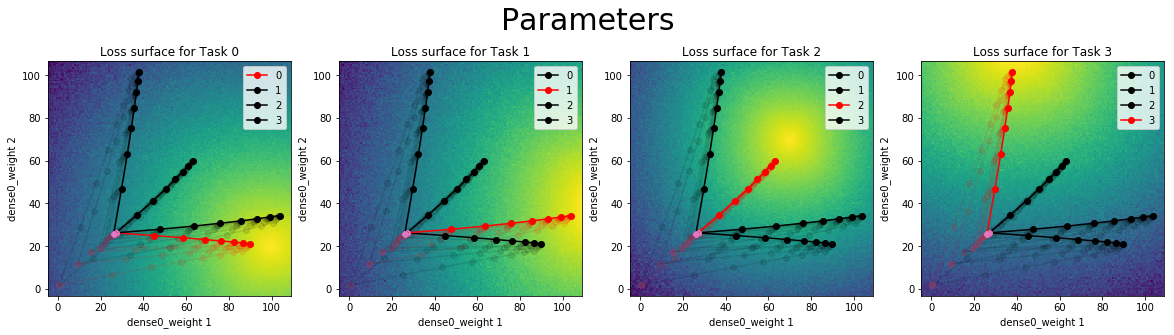

In [12]:
def real_fn(X, W):
    y = mx.nd.dot(X, mx.nd.expand_dims(W, axis=1))
    return y

def loss_fn(W_test, W_true, loss_samples=100):
    X = (mx.nd.random.uniform(shape=(loss_samples,2))-0.5)*100
    y_true = real_fn(X, W_true[1:])
    y_test = real_fn(X, W_test)
    loss = mx.nd.abs(y_true - y_test)
    return -mx.nd.mean(loss).asnumpy()[0]

lmr.meta_logger.plot_params(param='dense0_weight', W=W, loss_fn=loss_fn, loss_samples=200, gridsize=(150,150))